## Looptijden geplot per ministerie, per jaar

In elke plot staat een ministerie met de looptijden per jaar voor de rapporten Ondraaglijk Traag (2021), Matglas (2022) en 2023. 
De gemiddeldes staan met een rode ster gemarkeerd, en de middelste lijn in de gekleurde doosjes is de mediaan. 

Outliers worden niet laten zien, maar tellen wel mee in de berekening. Extreme outliers (de hoogste 0.05%) zijn compleet buiten beschouwing gelaten, dit is om de extreme foute looptijden te verwijderen.  

Als dagtekening wordt hier de kolom `foi_decisionDate` gebruikt.

In [1]:
# Imports
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
import pickle
from IPython.display import HTML
from scipy.stats import ks_2samp, mannwhitneyu, cramervonmises_2samp, anderson_ksamp

pd.options.mode.chained_assignment = None

In [2]:
def html(df):
    display(HTML(df.to_html(render_links=True, escape=False)))

In [3]:
minset = pd.read_pickle('../pipe/data/minfinal.pkl.gz')

In [4]:
minset['foi_publishedDate_dt'] = pd.to_datetime(minset['foi_publishedDate'], format='%Y-%m-%d')

In [5]:
minset['foi_publishedDate'].isna().value_counts(), minset['foi_publishedDate_dt'].isna().value_counts()

(foi_publishedDate
 False    106843
 True       1473
 Name: count, dtype: int64,
 foi_publishedDate_dt
 False    106843
 True       1473
 Name: count, dtype: int64)

## Filteren op datum

Het was voor mij onduidelijk hoe gefiltered is in het rapport Ondraaglijk Traag.  
Ik kon niet vinden waar staat bij welk ministerie welke periode is aangehouden.  

**2023:**  
Besluiten gepubliceerd op 1 januari 2023 tot en met 10 januari 2024, met een besluitdatum van 1 januari 2023, tot en met 31 december 2023.

**Matglas:**  
Besluiten gepubliceerd op 10 januari 2023 of eerder, met een beslisdatum van 1 januari 2022, tot en met 31 december 2022

**Ondraaglijk Traag:**  
In deze notebook heb ik de besluiten gepubliceerd in de periode oktober 2020 - september 2021 aangehouden, en voor het VWS besluiten gepubliceerd in de periode april 2019 - maart 2020.

Dit komt uit sectie 1.3 van het rapport Ondraaglijk Traag:  
`Dit onderzoek is uitgevoerd in de tweede helft van 2021. De kwantitatieve analyse van Wob-verzoeken is gemaakt
op basis van de op Rijksoverheid.nl gepubliceerde Wob-verzoeken. Het betreft cijfers van de Wob-verzoeken die
gepubliceerd zijn in de periode oktober 2020 – september 2021 (NB: bij sommige departementen is een iets
andere periode gehanteerd, bijvoorbeeld november 2020 – oktober 2021). Alleen bij het ministerie van VWS is
een afwijkende onderzoeksperiode gekozen (april 2019 – maart 2020) omdat dit voor VWS het laatste ‘normale
jaar’ was waarin nog geen sprake was van gepubliceerde corona-gerelateerde Wob-verzoeken.`

In [6]:
min2023 = minset.loc[(minset['foi_decisionDate'] <= '2023-12-31') & 
                     (minset['foi_decisionDate'] >= '2023-01-01') & 
                     (minset['foi_publishedDate'] <= '2024-01-10') & 
                     (minset['foi_publishedDate'] >= '2023-01-01') &
                     (minset.index.get_level_values(1) == 1)]


min2022EX = minset[(minset['foi_decisionDate'] >= '2022-01-01') & 
                   (minset['foi_decisionDate'] <= '2022-12-31') &
                   (minset['foi_publishedDate_dt'] <= '2023-01-10')]


min2021VWS = minset[(minset['dc_publisher_name'] == 'Ministerie Van Volksgezondheid, Welzijn En Sport') &
                    (minset['foi_publishedDate_dt'] >= '2019-04-01') &
                    (minset['foi_publishedDate_dt'] <= '2020-03-31')]

min2021NONVWS = minset[(minset['foi_publishedDate_dt'] >= '2020-10-01') & 
                       (minset['foi_publishedDate_dt'] <= '2021-09-30') &
                       (minset['dc_publisher_name'] != 'Ministerie Van Volksgezondheid, Welzijn En Sport')]

min2021EX = pd.concat([min2021NONVWS, min2021VWS])

In [7]:
display(min2023['foi_dossierType'].isna().value_counts())
min2023[min2023.index.get_level_values(1) == 1].groupby('dc_publisher_name')['foi_dossierType'].count()

foi_dossierType
False    1498
Name: count, dtype: int64

dc_publisher_name
Ministerie Van Algemene Zaken                                54
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties     95
Ministerie Van Buitenlandse Zaken                            60
Ministerie Van Defensie                                      54
Ministerie Van Economische Zaken En Klimaat                 116
Ministerie Van Financiën                                    212
Ministerie Van Infrastructuur En Waterstaat                 183
Ministerie Van Justitie En Veiligheid                       178
Ministerie Van Landbouw, Natuur En Voedselkwaliteit         344
Ministerie Van Onderwijs, Cultuur En Wetenschap              89
Ministerie Van Sociale Zaken En Werkgelegenheid              40
Ministerie Van Volksgezondheid, Welzijn En Sport             73
Name: foi_dossierType, dtype: int64

In [8]:
min2022MG = pd.read_pickle('data/ExcelToDF/sheetsMG.pkl.gz', compression='gzip')
min2021OT = pd.read_pickle('data/ExcelToDF/sheetsOT.pkl.gz', compression='gzip')

min2022MG.rename(columns={"Aantal dagen \nin behandeling": "looptijd_foi", "Ministerie": "dc_publisher_name"}, inplace=True)
min2021OT.rename(columns={"Aantal dagen \nin behandeling": "looptijd_foi", "Ministerie": "dc_publisher_name"}, inplace=True)

In [9]:
def verschil(row):
    dagtekening = row['dagtekening_complete']
    verzoek = row['verzoek_datum']
    if isinstance(dagtekening, datetime) and isinstance(verzoek, datetime):
        return dagtekening - verzoek
    else:
        return None
    
def verschil_foi(row):
    dagtekening = row['foi_decisionDate']
    verzoek = row['verzoek_datum']
    if isinstance(dagtekening, datetime) and isinstance(verzoek, datetime):
        return dagtekening - verzoek
    else:
        return None
        
def td_to_days(td):
    if td != None:
        return td.days

In [10]:
def remove_outliers_foi(df):
    limits = df[df['looptijd_foi'] >= 0].groupby('dc_publisher_name')['looptijd_foi'].quantile(0.995)
    loose_frames = []
    for ministerie in df['dc_publisher_name'].unique(): 
        min_filter = df[df['dc_publisher_name'] == ministerie]['looptijd_foi'] <= limits[ministerie]
        loose_frames.append(min_filter)

    cutoff_filter = pd.concat(loose_frames)
    df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]
    return df

In [11]:
minimum = 0

min2023['looptijd_foi'] = None
min2023['looptijd_foi'] = min2023.apply(lambda x: td_to_days(verschil_foi(x)), axis=1)
min2023['year'] = '2023'

min2022EX['looptijd_foi'] = None
min2022EX['looptijd_foi'] = min2022EX.apply(lambda x: td_to_days(verschil_foi(x)), axis=1)
min2022EX['year'] = '2022'

min2021EX['looptijd_foi'] = None
min2021EX['looptijd_foi'] = min2021EX.apply(lambda x: td_to_days(verschil_foi(x)), axis=1)
min2021EX['year'] = '2021'


min2022MG['year'] = '2022'
min2021OT['year'] = '2021'

# voor elk ministerie apart de extreme outliers weghalen (de hoogste 0.5%)
# als dit gebeurt voor de hele groep, blijven outliers van beter presterende ministeries staan
# zo hoop ik elk ministerie eerlijker te behandelen

min2023_cutoff = remove_outliers_foi(min2023)
min2022EX_cutoff = remove_outliers_foi(min2022EX)
min2021EX_cutoff = remove_outliers_foi(min2021EX)

print('Niet gefiltered op outliers')
display(min2023.groupby('dc_publisher_name')['looptijd_foi'].describe())
print('')
print('Alles boven de 0 weg, en per ministerie de hoogste 0.5% weg (alles boven quantile(0.995))')
display(remove_outliers_foi(min2023).groupby('dc_publisher_name')['looptijd_foi'].describe())

Niet gefiltered op outliers


C:\Users\Joran\AppData\Local\Temp\ipykernel_2212\3872202517.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]


,count,mean,std,min,25%,50%,75%,max
dc_publisher_name,,,,,,,,
Ministerie Van Algemene Zaken,54.0,147.685185,160.979880,0.0,38.25,102.5,176.00,901.0
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties,88.0,156.818182,211.366520,-247.0,52.00,101.0,172.00,1493.0
Ministerie Van Buitenlandse Zaken,59.0,128.915254,105.530236,9.0,47.00,113.0,178.00,596.0
Ministerie Van Defensie,48.0,124.208333,126.973101,8.0,33.75,69.0,166.75,551.0
Ministerie Van Economische Zaken En Klimaat,112.0,148.071429,128.735479,0.0,57.75,106.0,176.00,660.0
Ministerie Van Financiën,206.0,261.165049,356.597542,-79.0,105.75,184.5,320.75,3270.0
Ministerie Van Infrastructuur En Waterstaat,166.0,217.578313,259.606188,3.0,56.00,124.5,271.50,1222.0
Ministerie Van Justitie En Veiligheid,164.0,232.298780,292.172614,-5.0,85.50,139.5,261.00,2197.0
"Ministerie Van Landbouw, Natuur En Voedselkwaliteit",320.0,176.209375,284.078971,-1641.0,51.00,100.0,210.25,3372.0



Alles boven de 0 weg, en per ministerie de hoogste 0.5% weg (alles boven quantile(0.995))


,count,mean,std,min,25%,50%,75%,max
dc_publisher_name,,,,,,,,
Ministerie Van Algemene Zaken,53.0,133.471698,123.668229,0.0,36.00,101.0,167.00,525.0
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties,86.0,145.976744,150.615832,0.0,52.00,101.0,167.50,784.0
Ministerie Van Buitenlandse Zaken,58.0,120.862069,86.246779,9.0,46.00,109.5,171.00,465.0
Ministerie Van Defensie,47.0,115.127660,111.483595,8.0,33.50,67.0,158.50,457.0
Ministerie Van Economische Zaken En Klimaat,111.0,143.459459,119.664363,0.0,57.50,105.0,173.50,560.0
Ministerie Van Financiën,203.0,233.551724,200.489305,5.0,106.50,184.0,305.50,1535.0
Ministerie Van Infrastructuur En Waterstaat,165.0,211.490909,248.228593,3.0,56.00,124.0,270.00,1218.0
Ministerie Van Justitie En Veiligheid,162.0,221.635802,248.969148,0.0,87.25,139.5,260.75,1496.0
"Ministerie Van Landbouw, Natuur En Voedselkwaliteit",317.0,168.820189,188.951527,0.0,51.00,99.0,207.00,1044.0


In [12]:
# modified version of annotate function from: https://seaborn.pydata.org/generated/seaborn.FacetGrid.html

def annotate(data, **kws):
    n = len(data)
    p = data.groupby(['dc_publisher_name', 'year'])[['looptijd_foi']].count()
    ax = plt.gca()
    ax.text(.1, 0.9, f"N = {p.iloc[0,0]}", transform=ax.transAxes)
    ax.text(.45, 0.9, f"N = {p.iloc[1,0]}", transform=ax.transAxes)
    ax.text(.8, 0.9, f"N = {p.iloc[2,0]}", transform=ax.transAxes)

In [13]:
def compdia_plot(df1, df2, df3):
    plotframe = pd.concat([df1, df2, df3])

    bad = ['Ministerie Van Algemene Zaken',
           'Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties',
           'Ministerie Van Defensie', 
           'Ministerie Van Buitenlandse Zaken'
           ]

    good = ['Ministerie Van Financiën',
            'Ministerie Van Sociale Zaken En Werkgelegenheid',
            'Ministerie Van Economische Zaken En Klimaat', 
            'Ministerie Van Landbouw, Natuur En Voedselkwaliteit']

    same = ['Ministerie Van Onderwijs, Cultuur En Wetenschap',
            'Ministerie Van Infrastructuur En Waterstaat',
            'Ministerie Van Justitie En Veiligheid',
            'Ministerie Van Volksgezondheid, Welzijn En Sport', 
            ]

    bad_plotframe = plotframe.loc[(plotframe['dc_publisher_name'] == bad[0]) | 
                                   (plotframe['dc_publisher_name'] == bad[1]) | 
                                   (plotframe['dc_publisher_name'] == bad[2]) | 
                                   (plotframe['dc_publisher_name'] == bad[3])]

    same_plotframe = plotframe.loc[(plotframe['dc_publisher_name'] == same[0]) | 
                                   (plotframe['dc_publisher_name'] == same[1]) | 
                                   (plotframe['dc_publisher_name'] == same[2]) | 
                                   (plotframe['dc_publisher_name'] == same[3])]

    good_plotframe = plotframe.loc[(plotframe['dc_publisher_name'] == good[0]) | 
                                   (plotframe['dc_publisher_name'] == good[1]) | 
                                   (plotframe['dc_publisher_name'] == good[2]) | 
                                   (plotframe['dc_publisher_name'] == good[3])]

    bad = sns.catplot(data=bad_plotframe,
               x='year',
               y='looptijd_foi',
               col='dc_publisher_name',
               kind='box',
               showmeans=True,
               meanprops={"marker": "*",
                          "markerfacecolor": "red",
                          "markeredgecolor": "red"},
                showfliers=False
               )
    bad.set_titles("{col_name}")
    bad.map_dataframe(annotate)
    # bad.savefig('data/plots/CompDiaExcel/bad_plot.svg')

    same = sns.catplot(data=same_plotframe,
               x='year',
               y='looptijd_foi',
               col='dc_publisher_name',
               kind='box',
               showmeans=True,
               meanprops={"marker": "*",
                          "markerfacecolor": "red",
                          "markeredgecolor": "red"},
                showfliers=False
               )
    same.set_titles("{col_name}")
    same.map_dataframe(annotate)
    # same.savefig('data/plots/CompDiaExcel/same_plot.svg')

    good = sns.catplot(data=good_plotframe,
               x='year',
               y='looptijd_foi',
               col='dc_publisher_name',
               kind='box',
               showmeans=True,
               meanprops={"marker": "*",
                          "markerfacecolor": "red",
                          "markeredgecolor": "red"},
                showfliers=False
               )
    good.set_titles("{col_name}")
    good.map_dataframe(annotate)
    # good.savefig('data/plots/CompDiaExcel/good_plot.svg')

## Plots Handmatige data + 2023 automatisch

S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


looptijd_foi       \
                                                               count mean   
dc_publisher_name                                  year                     
Ministerie Van Algemene Zaken                      2021           29  100   
                                                   2022            8  148   
                                                   2023           53  133   
Ministerie Van Binnenlandse Zaken En Koninkrijk... 2021           76  158   
                                                   2022           92  138   
                                                   2023           86  145   
Ministerie Van Buitenlandse Zaken                  2021           51  139   
                                                   2022           70  123   
                                                   2023           58  120   
Ministerie Van Defensie                            2021           44   96   
                                                   2022           62  105   
                                                   2023           47  115   
Ministerie Van Economische Zaken En Klimaat        2021           97  150   
                                                   2022           92  184   
                                                   2023          111  143   
Ministerie Van Financiën                           2021          115  190   
                                                   2022          132  210   
                                                   2023          203  233   
Ministerie Van Infrastructuur En Waterstaat        2021           84  206   
                                                   2022          120  184   
                                                   2023          165  211   
Ministerie Van Justitie En Veiligheid              2021           85  187   
                                                   2022          109  189   
                                                   2023          162  221   
Ministerie Van Landbouw, Natuur En Voedselkwali... 2021          227  180   
                                                   2022          270  179   
                                                   2023          317  168   
Ministerie Van Onderwijs, Cultuur En Wetenschap    2021           49   74   
                                                   2022           59   70   
                                                   2023           80   79   
Ministerie Van Sociale Zaken En Werkgelegenheid    2021           65  128   
                                                   2022           45  173   
                                                   2023           38  167   
Ministerie Van Volksgezondheid, Welzijn En Sport   2021           59  157   
                                                   2022           18  143   
                                                   2023           68  177   

                                                                            \
                                                         std min  25%  50%   
dc_publisher_name                                  year                      
Ministerie Van Algemene Zaken                      2021   89  16   50   75   
                                                   2022   51  35  150  170   
                                                   2023  123   0   36  101   
Ministerie Van Binnenlandse Zaken En Koninkrijk... 2021  154  23   71  105   
                                                   2022  144   9   65  102   
                                                   2023  150   0   52  101   
Ministerie Van Buitenlandse Zaken                  2021  106   1   71  100   
                                                   2022  148   6   42   74   
                                                   2023   86   9   46  109   
Ministerie Van Defensie                            2021   89  15   41   74   
                                      

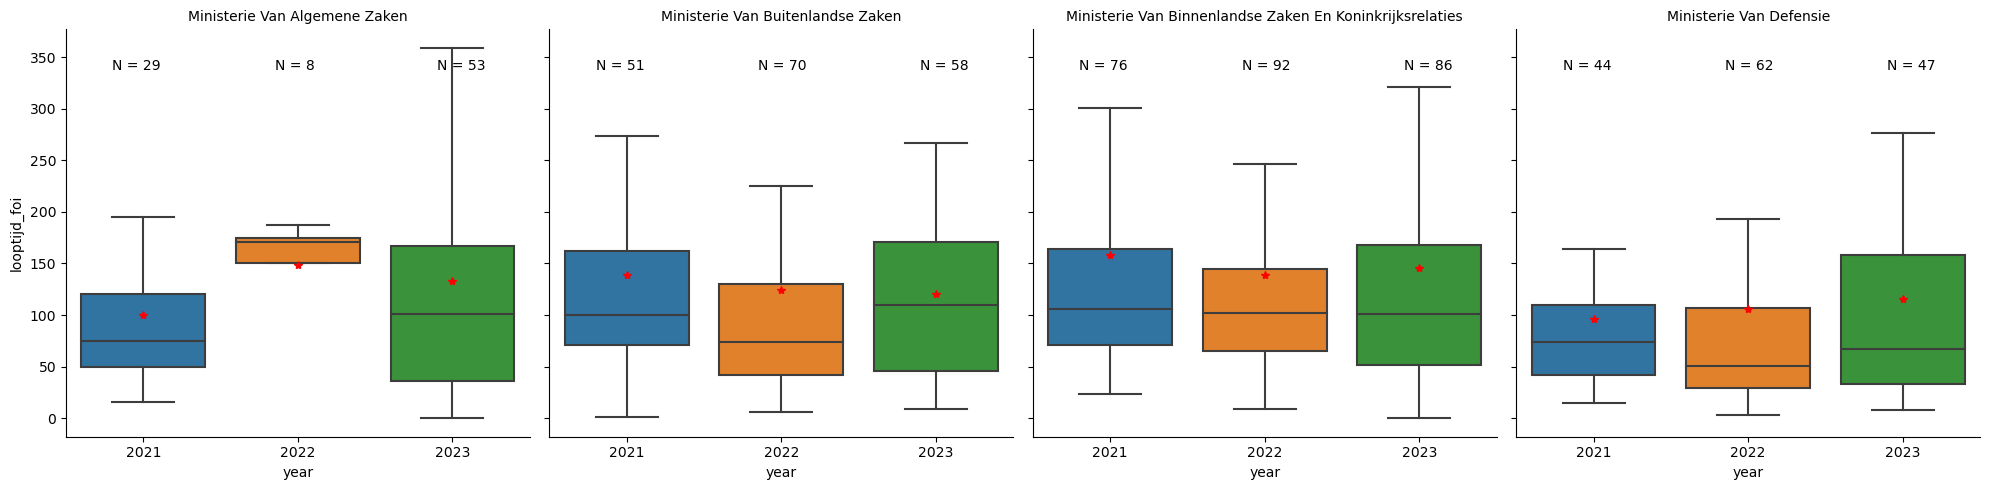

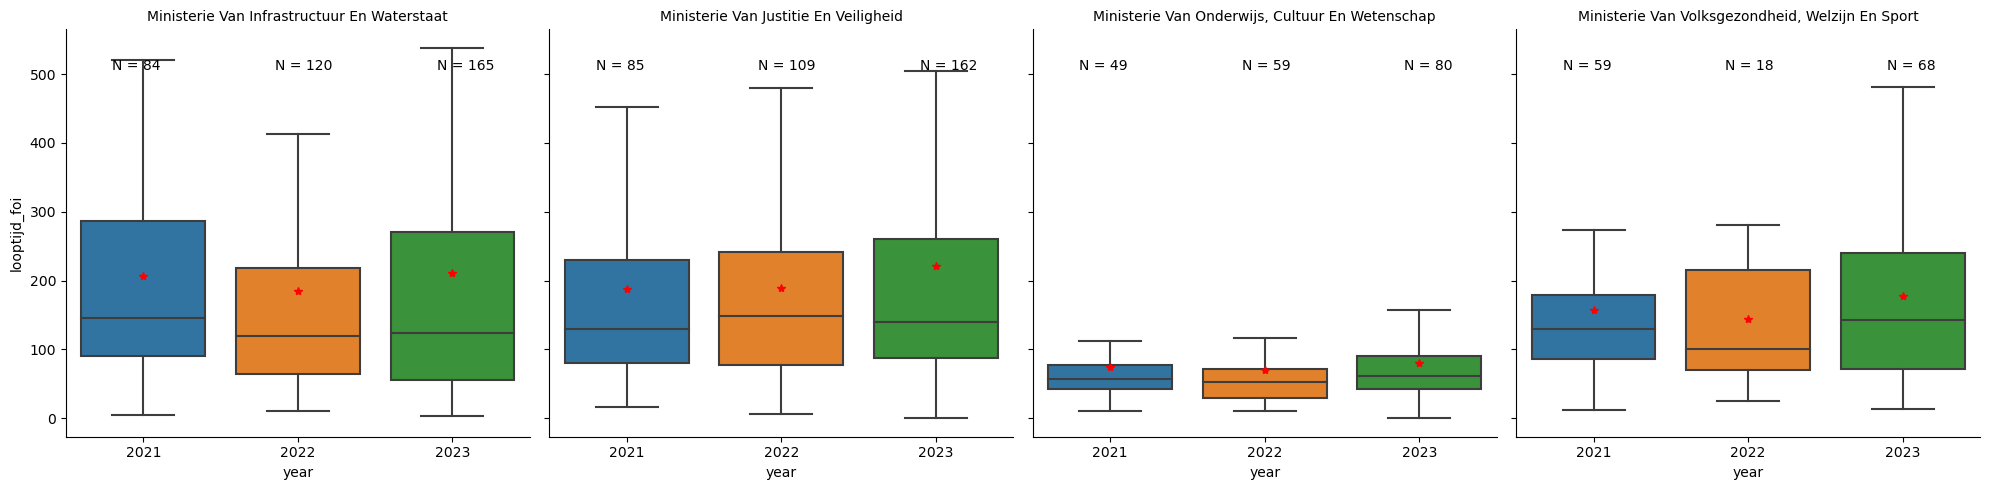

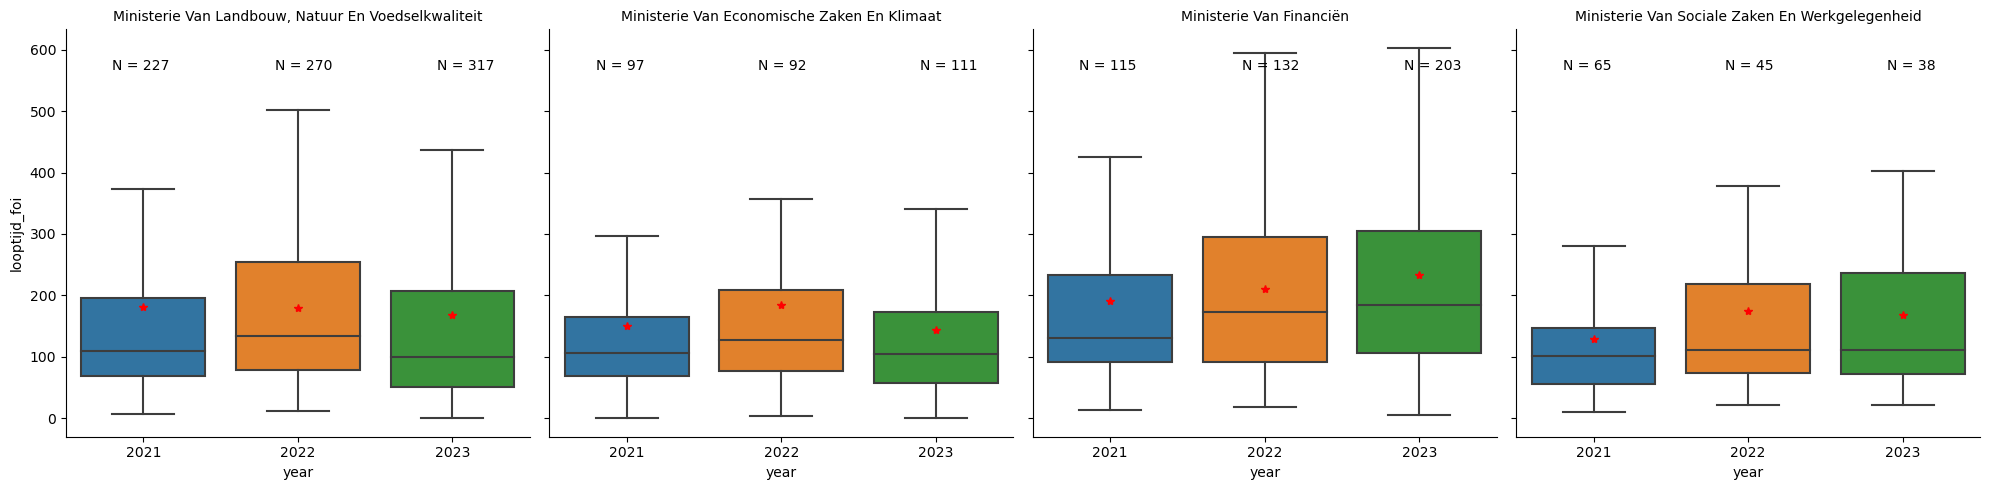

In [14]:
compdia_plot(min2021OT, min2022MG, min2023_cutoff[min2023_cutoff.index.get_level_values(1) == 1])

plotframe_excel = pd.concat([min2021OT, 
                           min2022MG, 
                           min2023_cutoff[min2023_cutoff.index.get_level_values(1) == 1]])

plotframe_excel.groupby(['dc_publisher_name', 'year'])[['looptijd_foi']].describe().astype(int)

# Plots Automatische data

S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


looptijd_foi       \
                                                               count mean   
dc_publisher_name                                  year                     
Ministerie Van Algemene Zaken                      2021           27  116   
                                                   2022            7  166   
                                                   2023           53  133   
Ministerie Van Binnenlandse Zaken En Koninkrijk... 2021           74  185   
                                                   2022           91  146   
                                                   2023           86  145   
Ministerie Van Buitenlandse Zaken                  2021           52  153   
                                                   2022           72  148   
                                                   2023           58  120   
Ministerie Van Defensie                            2021           30   90   
                                                   2022           59  150   
                                                   2023           47  115   
Ministerie Van Economische Zaken En Klimaat        2021           91  171   
                                                   2022           89  222   
                                                   2023          111  143   
Ministerie Van Financiën                           2021          103  202   
                                                   2022          134  245   
                                                   2023          203  233   
Ministerie Van Infrastructuur En Waterstaat        2021           92  259   
                                                   2022          127  244   
                                                   2023          165  211   
Ministerie Van Justitie En Veiligheid              2021           87  193   
                                                   2022          134  198   
                                                   2023          162  221   
Ministerie Van Landbouw, Natuur En Voedselkwali... 2021          236  202   
                                                   2022          259  204   
                                                   2023          317  168   
Ministerie Van Onderwijs, Cultuur En Wetenschap    2021           42   70   
                                                   2022           45   67   
                                                   2023           80   79   
Ministerie Van Sociale Zaken En Werkgelegenheid    2021           70  252   
                                                   2022           47  299   
                                                   2023           38  167   
Ministerie Van Volksgezondheid, Welzijn En Sport   2021           22  170   
                                                   2022           40  223   
                                                   2023           68  177   

                                                                             \
                                                         std  min  25%  50%   
dc_publisher_name                                  year                       
Ministerie Van Algemene Zaken                      2021  109   28   48   83   
                                                   2022   22  118  166  173   
                                                   2023  123    0   36  101   
Ministerie Van Binnenlandse Zaken En Koninkrijk... 2021  179    0   77  124   
                                                   2022  146    9   69  112   
                                                   2023  150    0   52  101   
Ministerie Van Buitenlandse Zaken                  2021  105   32   84  132   
                                                   2022  124    6   61   96   
                                                   2023   86    9   46  109   
Ministerie Van Defensie                            2021   83   15   44   69   
                         

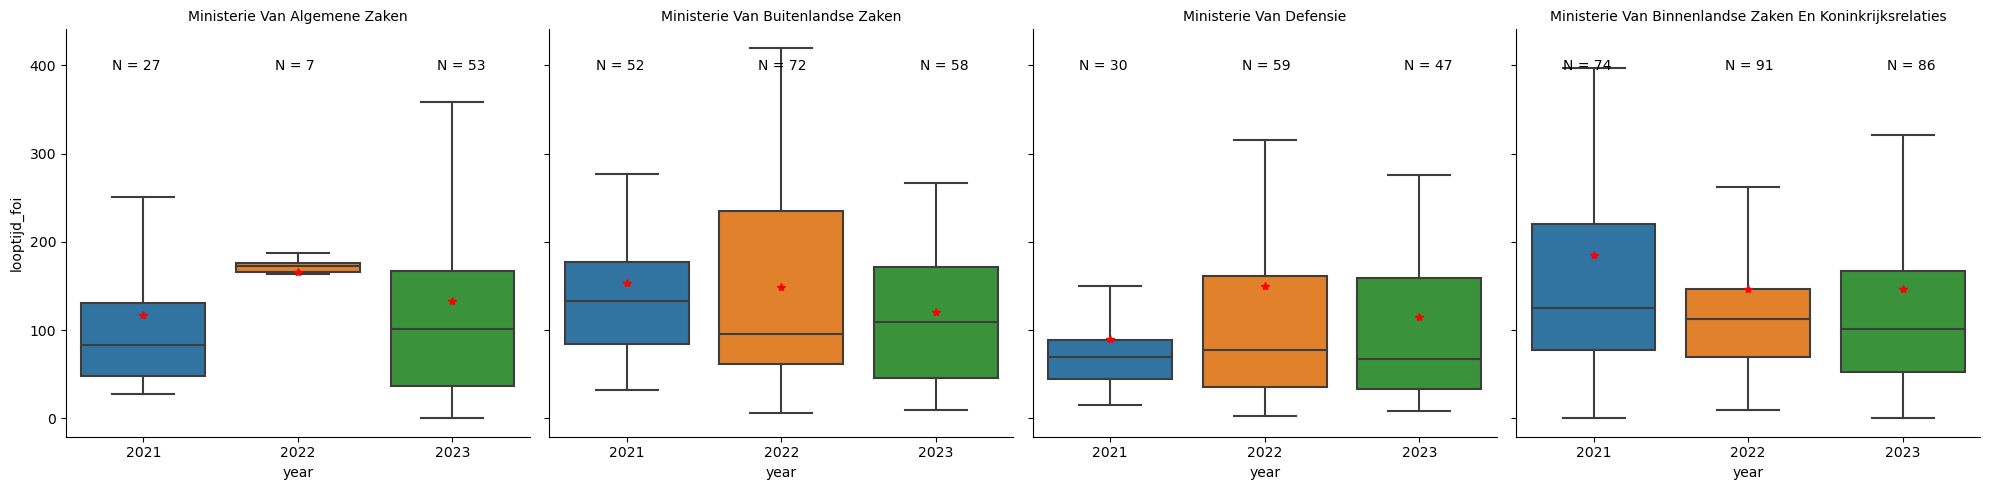

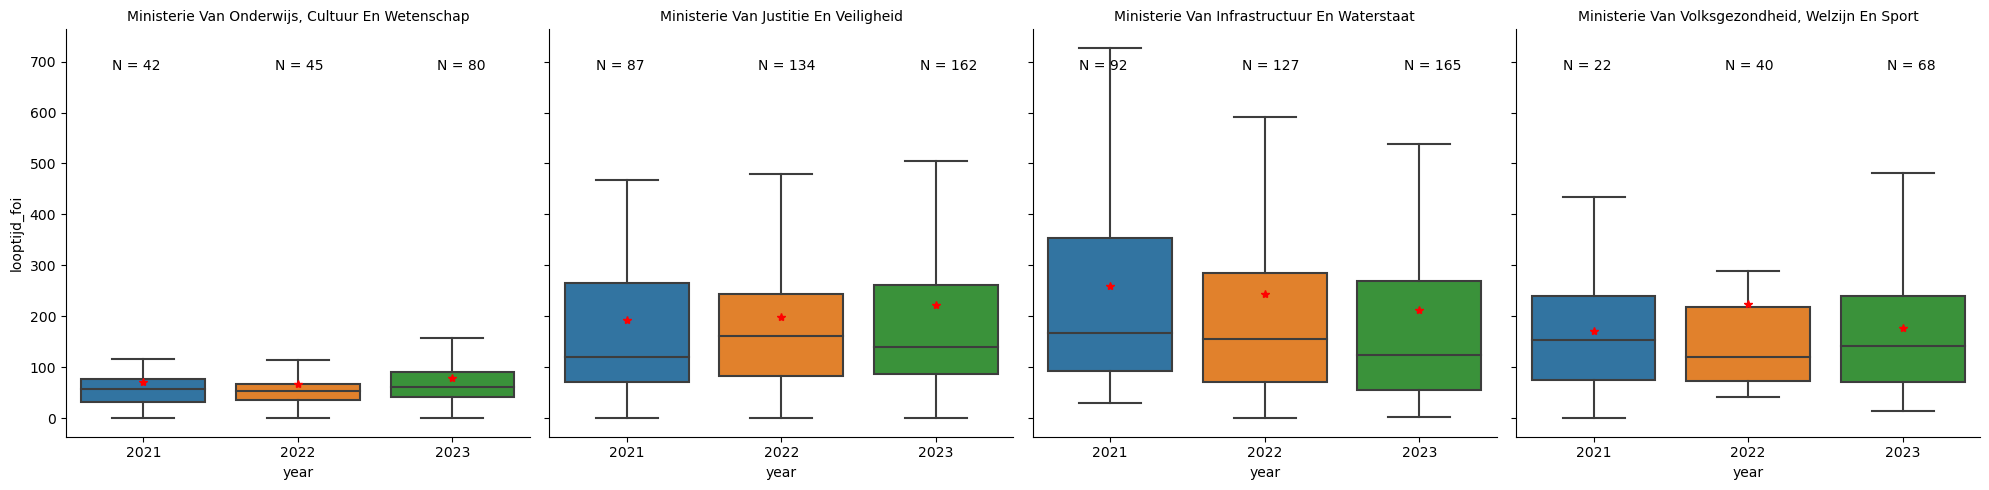

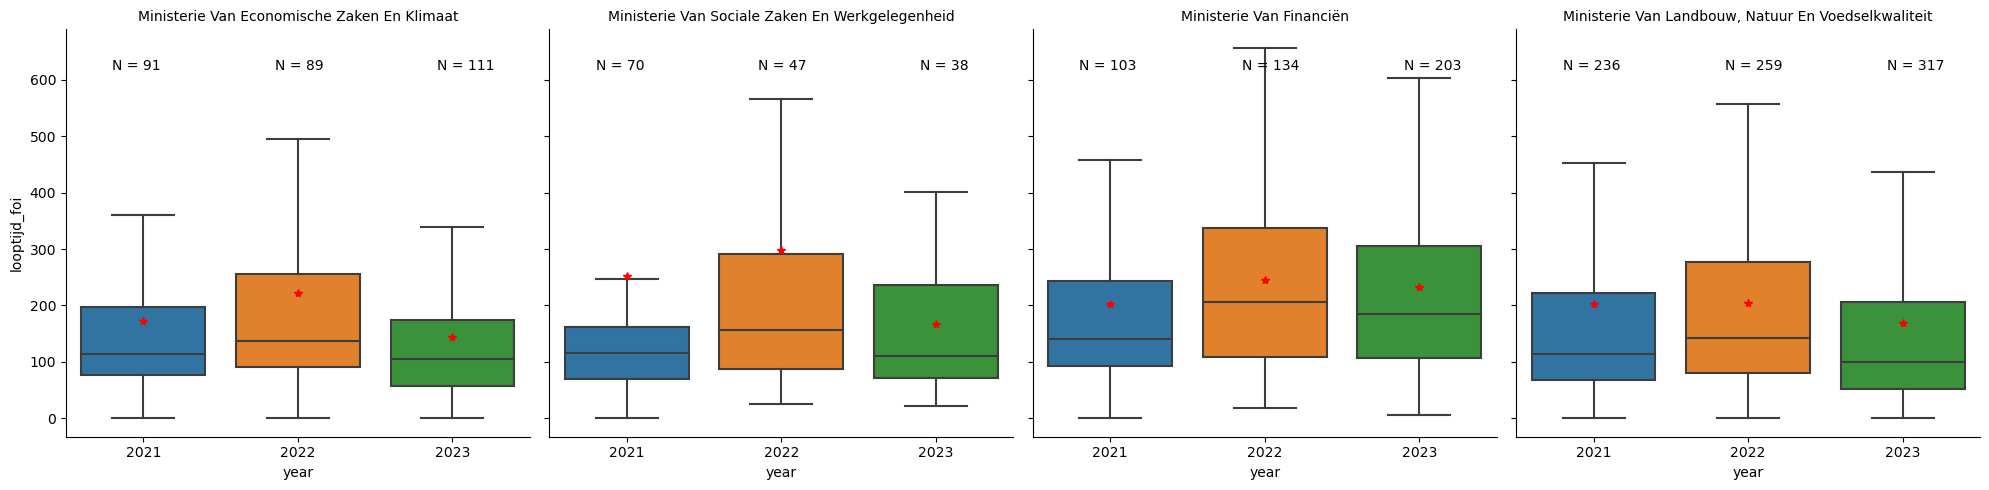

In [15]:
compdia_plot(min2021EX_cutoff[min2021EX_cutoff.index.get_level_values(1) == 1],
             min2022EX_cutoff[min2022EX_cutoff.index.get_level_values(1) == 1],
             min2023_cutoff[min2023_cutoff.index.get_level_values(1) == 1])

plotframe_extractor = pd.concat([min2021EX_cutoff[min2021EX_cutoff.index.get_level_values(1) == 1], 
                                 min2022EX_cutoff[min2022EX_cutoff.index.get_level_values(1) == 1], 
                                 min2023_cutoff[min2023_cutoff.index.get_level_values(1) == 1]])

plotframe_extractor.groupby(['dc_publisher_name', 'year'])[['looptijd_foi']].describe().astype(int)